In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from tqdm.notebook import tqdm
import random
import torch

# --- 实验设置 ---
T = 8000                 # 我们将创建 6000 步的数据流
TARGET_ALPHA = 0.1       # 我们的长期目标 α

# --- 算法 1: 原版 ACI (固定 γ) ---
GAMMA_FIXED = 0.05       # 一个"调得还行"的固定 γ

# --- 算法 2: 我们的 ACI-CF (动态 γ_t, 使用 RMD) ---
GAMMA_MIN = 0.01         # 最小 γ
GAMMA_MAX = 0.15         # 最大 γ
WINDOW_SIZE = 100        # 用于 error gap / local error 的窗口大小

# --- MMLU 主题定义 ---
DATA_FILE = "mmlu_with_aps_scores.csv"
try:
    df_temp = pd.read_csv(DATA_FILE)
    all_subjects = sorted(df_temp['subject'].unique())
    print(f"CSV中所有可用的subjects ({len(all_subjects)}个):")
    print(all_subjects)
    print()
    
    # 随机选择用于校准和测试的subjects
    random.seed(42)  # 设置随机种子以便结果可复现
    selected_subjects = random.sample(all_subjects, min(2, len(all_subjects)))
    CALIBRATION_SUBJECTS = selected_subjects[:1]
    TEST_STREAM_SUBJECTS = selected_subjects[1:]
    
    print(f"随机选择的校准subjects ({len(CALIBRATION_SUBJECTS)}个): {CALIBRATION_SUBJECTS}")
    print(f"随机选择的测试subjects ({len(TEST_STREAM_SUBJECTS)}个): {TEST_STREAM_SUBJECTS}")
except FileNotFoundError:
    print(f"警告: 未找到 {DATA_FILE}")


CSV中所有可用的subjects (19个):
['abstract_algebra', 'anatomy', 'astronomy', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology']

随机选择的校准subjects (1个): ['business_ethics']
随机选择的测试subjects (1个): ['abstract_algebra']


In [136]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

print("SentenceTransformer library loaded.")


SentenceTransformer library loaded.


In [137]:
# -----------------------------------------------------------------
# Section 2: 加载数据 & 创建 *分裂的* "固定模型" Q_hat
# -----------------------------------------------------------------

from sklearn.model_selection import train_test_split

# 加载数据
DATA_FILE = "mmlu_with_aps_scores.csv"
try:
    df_scores = pd.read_csv(DATA_FILE)
    print(f"成功加载 {len(df_scores)} 行 MMLU 数据。")
except FileNotFoundError:
    print(f"错误: 未找到 {DATA_FILE}")
    print("请确保你已成功运行第一个 notebook 并生成了该文件。")


# --- 1. 划分"校准主题"和"OOD主题" ---
df_cal_pool = df_scores[df_scores['subject'].isin(CALIBRATION_SUBJECTS)]
df_ood_pool = df_scores[df_scores['subject'].isin(TEST_STREAM_SUBJECTS)]

# --- 2. 找到"校准主题"的所有唯一 question_id ---
cal_all_qids = df_cal_pool['question_id'].unique()
print(f"从 {len(CALIBRATION_SUBJECTS)} 个校准主题中找到 {len(cal_all_qids)} 个唯一的问题。")

# --- 3. 将这些问题 50/50 分裂 ---
# D_cal 用于构建 Q_hat
# D_test_id 用于模拟"稳定/分布内"的测试流
cal_qids, test_id_qids = train_test_split(cal_all_qids, test_size=0.5, random_state=42)

print(f" -> {len(cal_qids)} 个问题用于构建 Q_hat (Calibration)")
print(f" -> {len(test_id_qids)} 个问题用于稳定测试流 (In-Distribution Test)")


# --- 4. 创建我们的"固定模型" Q_hat ---
df_cal = df_scores[df_scores['question_id'].isin(cal_qids)]
calibration_scores = df_cal[df_cal['is_ground_truth'] == True]['aps_score'].values
print(f"\n成功从 {len(calibration_scores)} 个校准分数构建 Q_hat。")

# 我们的模型 Q_hat(q) 就是这些校准分数的 *经验分位数* 函数
def hat_Q(q_level):
    if q_level <= 0: return -np.inf
    if q_level >= 1: return np.inf
    # 使用 'higher' 来匹配 (n+1)/n 的保守估计
    return np.quantile(calibration_scores, q_level, method='higher')

# 测试一下我们的 Q_hat
q_90 = hat_Q(1.0 - TARGET_ALPHA)
print(f"我们的固定阈值 q_hat (在 α=0.1 时) 是: {q_90:.4f}")


成功加载 11916 行 MMLU 数据。
从 1 个校准主题中找到 100 个唯一的问题。
 -> 50 个问题用于构建 Q_hat (Calibration)
 -> 50 个问题用于稳定测试流 (In-Distribution Test)

成功从 50 个校准分数构建 Q_hat。
我们的固定阈值 q_hat (在 α=0.1 时) 是: 0.2560


In [138]:
# -----------------------------------------------------------------
# *** 预计算所有 MMLU 问题的 Embeddings ***
# -----------------------------------------------------------------
print("\n--- 正在预计算 Embeddings ---")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. 加载一个轻量级的 SBERT 模型
embed_model = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE)

# 2. 获取 *所有* 唯一的 MMLU 问题 (来自 df_scores)
unique_questions = df_scores[['question_id', 'question']].drop_duplicates().set_index('question_id')
question_texts = unique_questions['question'].tolist()
question_ids = unique_questions.index.tolist()

print(f"正在为 {len(question_texts)} 个唯一问题计算 embeddings...")

# 3. 计算所有 embeddings
question_embeddings = embed_model.encode(
    question_texts, 
    batch_size=32, 
    show_progress_bar=True, 
    device=DEVICE
)

print("Embeddings 计算完成。")

# 4. 创建一个从 question_id -> embedding 的快速查找字典
embedding_map = {qid: emb for qid, emb in zip(question_ids, question_embeddings)}

# 5. 将 embeddings 添加到我们的主 DataFrame 中
df_scores['embedding'] = df_scores['question_id'].map(embedding_map)
print("Embeddings 已合并回主 DataFrame。")



--- 正在预计算 Embeddings ---


正在为 2979 个唯一问题计算 embeddings...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings 计算完成。
Embeddings 已合并回主 DataFrame。


In [139]:
# -----------------------------------------------------------------
# Section 3: 创建"连续跳跃"测试数据流（多个 jump，多个 non-iid subjects）
# -----------------------------------------------------------------

# --- 1. 准备好我们的问题"池" ---

# (A) "稳定 / 分布内" (ID) 问题池
df_test_id_data = df_scores[df_scores['question_id'].isin(test_id_qids)]
df_test_id_gt = df_test_id_data[df_test_id_data['is_ground_truth'] == True].copy()
df_test_id_gt = df_test_id_gt.rename(columns={'choice_index': 'ground_truth_label'})
pool_id = df_test_id_gt[['question_id', 'ground_truth_label', 'embedding']]
print(f"创建了 {len(pool_id)} 个问题的稳定 (ID) 池。")

# (B) "剧变 / 分布外" (OOD) 问题池 - 按 subject 分组
df_test_ood_data = df_scores[df_scores['subject'].isin(TEST_STREAM_SUBJECTS)]
df_test_ood_gt = df_test_ood_data[df_test_ood_data['is_ground_truth'] == True].copy()
df_test_ood_gt = df_test_ood_gt.rename(columns={'choice_index': 'ground_truth_label'})

# 按 subject 分组，为每个 subject 创建独立的池
pool_ood_by_subject = {}
for subject in TEST_STREAM_SUBJECTS:
    subject_data = df_test_ood_gt[df_test_ood_gt['question_id'].str.startswith(subject)]
    if len(subject_data) > 0:
        pool_ood_by_subject[subject] = subject_data[['question_id', 'ground_truth_label', 'embedding']]
        print(f"  Subject '{subject}': {len(pool_ood_by_subject[subject])} 个问题")

print(f"\n总共创建了 {len(pool_ood_by_subject)} 个 OOD subject 池。")

# --- 2. 创建 6000 步的"连续跳跃"数据流 ---
# 设计：多个连续的 jump，每个 jump 使用不同的 subject
# 例如：稳定 -> jump1(subject1) -> 稳定 -> jump2(subject2) -> 稳定 -> ...

NUM_JUMPS = 2  # 连续 jump 的数量
STABLE_SEGMENT_SIZE = 2000
JUMP_SEGMENT_SIZE = 1000

print(f"\n数据流设计:")
print(f"  总长度: {T}")
print(f"  Jump 数量: {NUM_JUMPS}")
print(f"  每个稳定段长度: {STABLE_SEGMENT_SIZE}")
print(f"  每个 jump 段长度: {JUMP_SEGMENT_SIZE}")

test_stream_list = []
jump_subjects_used = []  # 记录每个 jump 使用的 subject
time_segment_info = []  # 记录每个时间段的信息: (start, end, subject_type, subject_name)

random.seed(42)
available_subjects = list(pool_ood_by_subject.keys())

current_time = 0
ID_SUBJECT_NAME = "ID (stable)"  # 稳定段的标识

for i in range(NUM_JUMPS + 1):
    # 稳定段
    stable_segment = pool_id.sample(n=STABLE_SEGMENT_SIZE, replace=True)
    test_stream_list.append(stable_segment)
    
    segment_start = current_time
    segment_end = current_time + len(stable_segment)
    time_segment_info.append((segment_start, segment_end, ID_SUBJECT_NAME, CALIBRATION_SUBJECTS[0] if len(CALIBRATION_SUBJECTS) > 0 else "ID"))
    current_time = segment_end
    
    # 如果不是最后一个稳定段，添加一个 jump 段
    if i < NUM_JUMPS:
        # 随机选择一个 subject（确保每个 jump 使用不同的 subject）
        if len(available_subjects) > 0:
            selected_subject = random.choice(available_subjects)
            available_subjects.remove(selected_subject)  # 移除已使用的 subject
            jump_subjects_used.append(selected_subject)
            
            pool_ood_jump = pool_ood_by_subject[selected_subject]
            print(f"  Jump {i+1}: 使用 subject '{selected_subject}' ({len(pool_ood_jump)} 个问题)")
            jump_segment = pool_ood_jump.sample(n=JUMP_SEGMENT_SIZE, replace=True)
            test_stream_list.append(jump_segment)
            
            segment_start = current_time
            segment_end = current_time + len(jump_segment)
            time_segment_info.append((segment_start, segment_end, "OOD (jump)", selected_subject))
            current_time = segment_end
        else:
            # 如果没有更多可用的 subject，重复使用之前的
            selected_subject = random.choice(list(pool_ood_by_subject.keys()))
            jump_subjects_used.append(selected_subject)
            pool_ood_jump = pool_ood_by_subject[selected_subject]
            print(f"  Jump {i+1}: 重复使用 subject '{selected_subject}' ({len(pool_ood_jump)} 个问题)")
            jump_segment = pool_ood_jump.sample(n=JUMP_SEGMENT_SIZE, replace=True)
            test_stream_list.append(jump_segment)
            
            segment_start = current_time
            segment_end = current_time + len(jump_segment)
            time_segment_info.append((segment_start, segment_end, "OOD (jump)", selected_subject))
            current_time = segment_end

# 将数据流（DataFrames 列表）合并为一个 DataFrame
test_stream_df = pd.concat(test_stream_list).reset_index(drop=True)

# 确保总长度为 T
if len(test_stream_df) > T:
    test_stream_df = test_stream_df.iloc[:T]
    # 更新最后一个段的结束时间
    if len(time_segment_info) > 0:
        last_start, _, last_type, last_subject = time_segment_info[-1]
        time_segment_info[-1] = (last_start, T, last_type, last_subject)
elif len(test_stream_df) < T:
    # 如果不够，从 pool_id 中补充
    remaining = T - len(test_stream_df)
    test_stream_df = pd.concat([test_stream_df, pool_id.sample(n=remaining, replace=True)]).reset_index(drop=True)
    # 更新最后一个段的结束时间，或者添加新的段
    if len(time_segment_info) > 0 and time_segment_info[-1][1] < T:
        last_start, _, last_type, last_subject = time_segment_info[-1]
        time_segment_info[-1] = (last_start, T, last_type, last_subject)

# --- 3. 将完整的、带所有选项（A,B,C,D）分数的数据合并进来 ---
test_stream_full_df = test_stream_df[['question_id', 'ground_truth_label']].merge(
    df_scores,
    on='question_id',
    suffixes=('_stream', '_choices')
)

print(f"\n成功创建了 {len(test_stream_df)} 步的 MMLU '连续跳跃' 数据流。")
print(f"使用的 jump subjects: {jump_subjects_used}")

# --- 4. 打印整个T时间内的分布变化 ---
print(f"\n{'='*80}")
print("整个T时间内的分布变化 (时间段 -> Subject):")
print(f"{'='*80}")
print(f"{'时间段':<20} {'长度':<10} {'类型':<15} {'Subject':<30}")
print(f"{'-'*80}")
for start, end, seg_type, subject in time_segment_info:
    length = end - start
    print(f"[{start:5d}, {end:5d})  {length:<10} {seg_type:<15} {subject:<30}")
print(f"{'='*80}")
print(f"\n总长度: {len(test_stream_df)} 步 (T = {T})")
print(f"{'='*80}\n")

print(test_stream_df.head())


创建了 50 个问题的稳定 (ID) 池。
  Subject 'abstract_algebra': 100 个问题

总共创建了 1 个 OOD subject 池。

数据流设计:
  总长度: 8000
  Jump 数量: 2
  每个稳定段长度: 2000
  每个 jump 段长度: 1000
  Jump 1: 使用 subject 'abstract_algebra' (100 个问题)
  Jump 2: 重复使用 subject 'abstract_algebra' (100 个问题)

成功创建了 8000 步的 MMLU '连续跳跃' 数据流。
使用的 jump subjects: ['abstract_algebra', 'abstract_algebra']

整个T时间内的分布变化 (时间段 -> Subject):
时间段                  长度         类型              Subject                       
--------------------------------------------------------------------------------
[    0,  2000)  2000       ID (stable)     business_ethics               
[ 2000,  3000)  1000       OOD (jump)      abstract_algebra              
[ 3000,  5000)  2000       ID (stable)     business_ethics               
[ 5000,  6000)  1000       OOD (jump)      abstract_algebra              
[ 6000,  8000)  2000       ID (stable)     business_ethics               

总长度: 8000 步 (T = 8000)

          question_id  ground_truth_label  \
0  business_ethics_3

成功预生成 8000 个时间步的 Embedding 向量。
Embedding 维度: 384
Embedding 统计: mean=-0.0013, std=0.0510

In-domain samples: 500 / 8000
In-domain mean vector shape: (384,)
In-domain covariance matrix shape: (384, 384)
Background mean vector shape: (384,)
Background covariance matrix shape: (384, 384)

Mahalanobis distance 统计:
  md_in: mean=219601.1903, std=382824.2141, min=25.2638, max=1077129.5799
  md_bg: mean=148.1195, std=150.3020, min=53.0377, max=792.3100
  rmd_raw: mean=219453.0708, std=382683.1008, min=-39.5773, max=1076633.9549

ood_prob range: 0.0000, 1.0000


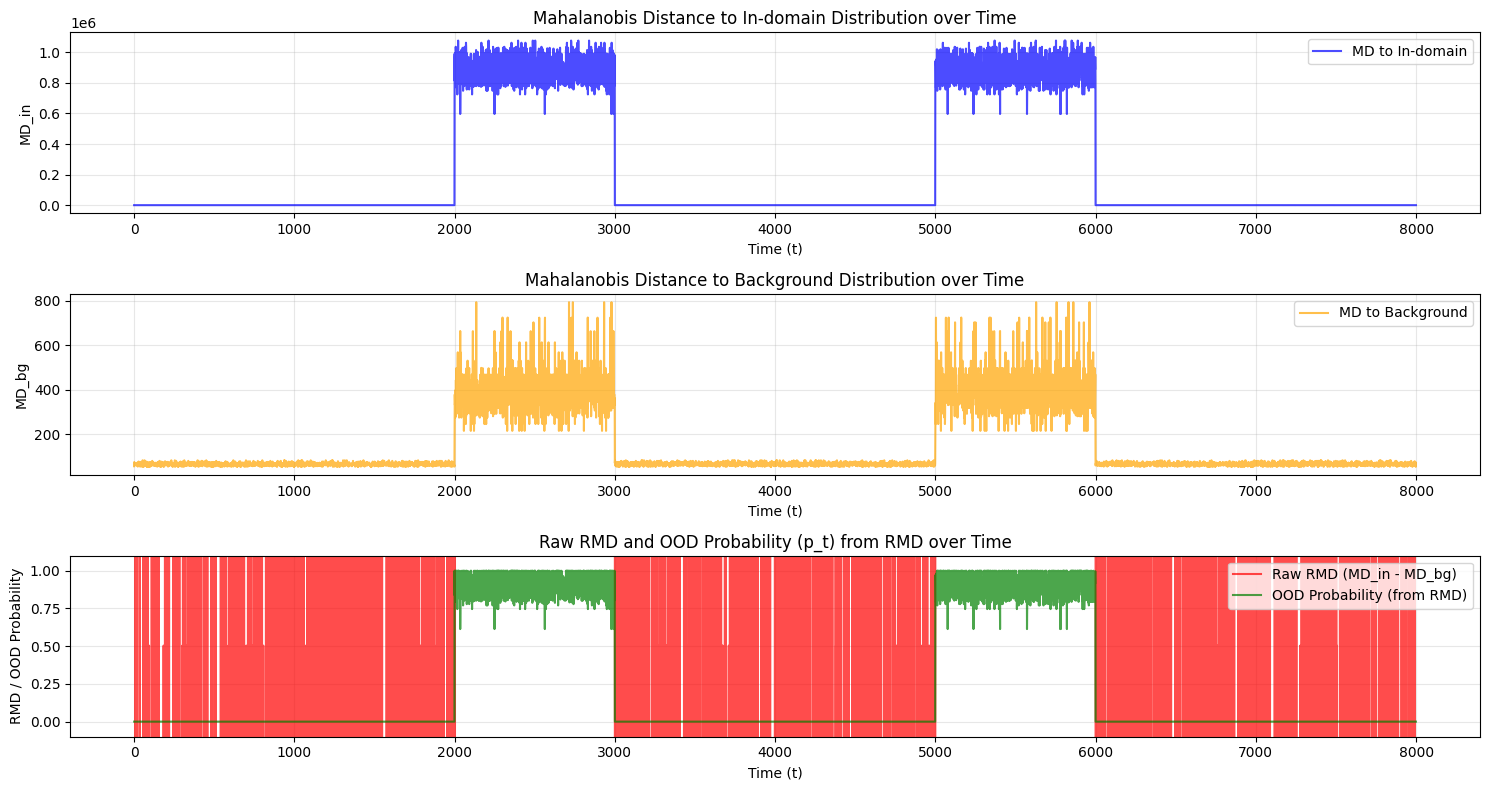

In [140]:
# -----------------------------------------------------------------
# Section 4: 计算 RMD 并用于控制 gamma（基于论文方法：使用 embedding 和多元高斯）
# -----------------------------------------------------------------

# === 预生成整条真实轨迹的 Embedding 向量，用于 RMD 计算 ===
# 按照论文方法：收集训练集（In-domain）中所有输入文本的 embedding 向量

# 1) 收集每个时间步的 embedding 向量
Z_full = []  # 存储每个时间步的 embedding 向量

for t in range(T):
    current_question_id = test_stream_df.loc[t, 'question_id']
    # 从 test_stream_df 中获取该问题的 embedding
    embedding = test_stream_df.loc[t, 'embedding']
    # 确保 embedding 是 numpy 数组
    if isinstance(embedding, list):
        embedding = np.array(embedding)
    Z_full.append(embedding)

Z_full = np.array(Z_full)  # Shape: (T, embedding_dim)
print(f"成功预生成 {len(Z_full)} 个时间步的 Embedding 向量。")
print(f"Embedding 维度: {Z_full.shape[1]}")
print(f"Embedding 统计: mean={Z_full.mean():.4f}, std={Z_full.std():.4f}")

# === 拟合 in-domain / background 多元高斯分布，并计算 RMD ===

# 1) 用 "接近基础状态" 的时间步作为 in-domain 样本
#    在 jump 场景中，我们选择前一部分稳定段作为 in-domain
in_domain_size = min(500, T // 4)
Z_in = Z_full[:in_domain_size]  # Shape: (in_domain_size, embedding_dim)
Z_bg = Z_full  # 背景就用整条轨迹

# 2) 计算 In-domain 的多元高斯分布参数
#    经验均值向量 μ_in 和经验协方差矩阵 Σ_in
mu_in = np.mean(Z_in, axis=0)  # Shape: (embedding_dim,)
# 使用样本协方差矩阵（ddof=1 表示除以 n-1）
Sigma_in = np.cov(Z_in.T, ddof=1)  # Shape: (embedding_dim, embedding_dim)

# 3) 计算 Background 的多元高斯分布参数
mu_bg = np.mean(Z_bg, axis=0)  # Shape: (embedding_dim,)
Sigma_bg = np.cov(Z_bg.T, ddof=1)  # Shape: (embedding_dim, embedding_dim)

print(f"\nIn-domain samples: {len(Z_in)} / {T}")
print(f"In-domain mean vector shape: {mu_in.shape}")
print(f"In-domain covariance matrix shape: {Sigma_in.shape}")
print(f"Background mean vector shape: {mu_bg.shape}")
print(f"Background covariance matrix shape: {Sigma_bg.shape}")

# 4) 处理协方差矩阵可能奇异的问题（添加正则化项）
#    使用正则化：Σ_reg = Σ + λ * I，其中 λ 是一个小的正数
REGULARIZATION_LAMBDA = 1e-6
I = np.eye(Sigma_in.shape[0])
Sigma_in_reg = Sigma_in + REGULARIZATION_LAMBDA * I
Sigma_bg_reg = Sigma_bg + REGULARIZATION_LAMBDA * I

# 5) 计算协方差矩阵的逆（用于 Mahalanobis 距离）
#    使用伪逆（pinv）以处理可能的数值问题
try:
    Sigma_in_inv = np.linalg.inv(Sigma_in_reg)
except np.linalg.LinAlgError:
    print("警告: Sigma_in 奇异，使用伪逆")
    Sigma_in_inv = np.linalg.pinv(Sigma_in_reg)

try:
    Sigma_bg_inv = np.linalg.inv(Sigma_bg_reg)
except np.linalg.LinAlgError:
    print("警告: Sigma_bg 奇异，使用伪逆")
    Sigma_bg_inv = np.linalg.pinv(Sigma_bg_reg)

# 6) 计算每个时间步的 Mahalanobis 距离和 RMD
#    Mahalanobis 距离公式: MD = (z - μ)^T Σ^(-1) (z - μ)
md_in = np.zeros(T)
md_bg = np.zeros(T)

for t in range(T):
    z_t = Z_full[t]  # 当前时间步的 embedding 向量
    
    # 计算相对于 in-domain 的 Mahalanobis 距离
    diff_in = z_t - mu_in
    md_in[t] = diff_in.T @ Sigma_in_inv @ diff_in
    
    # 计算相对于 background 的 Mahalanobis 距离
    diff_bg = z_t - mu_bg
    md_bg[t] = diff_bg.T @ Sigma_bg_inv @ diff_bg

# RMD = md_in - md_bg（越大越 OOD，类比 Ren 的 RMD）
rmd_raw = md_in - md_bg

print(f"\nMahalanobis distance 统计:")
print(f"  md_in: mean={md_in.mean():.4f}, std={md_in.std():.4f}, min={md_in.min():.4f}, max={md_in.max():.4f}")
print(f"  md_bg: mean={md_bg.mean():.4f}, std={md_bg.std():.4f}, min={md_bg.min():.4f}, max={md_bg.max():.4f}")
print(f"  rmd_raw: mean={rmd_raw.mean():.4f}, std={rmd_raw.std():.4f}, min={rmd_raw.min():.4f}, max={rmd_raw.max():.4f}")

# 7) 把 RMD 映射到 [0, 1] 得到 OOD 概率 p_t
#    用分位数做一个稳一点的 min-max，避免极端值
low = np.percentile(rmd_raw, 5)
high = np.percentile(rmd_raw, 95)
rmd_clipped = np.clip(rmd_raw, low, high)
ood_prob = (rmd_clipped - low) / (high - low + 1e-8)

print(f"\nood_prob range: {ood_prob.min():.4f}, {ood_prob.max():.4f}")

# 可视化 RMD 和 ood_prob
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(md_in, label='MD to In-domain', color='blue', alpha=0.7)
plt.title('Mahalanobis Distance to In-domain Distribution over Time')
plt.xlabel('Time (t)')
plt.ylabel('MD_in')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(md_bg, label='MD to Background', color='orange', alpha=0.7)
plt.title('Mahalanobis Distance to Background Distribution over Time')
plt.xlabel('Time (t)')
plt.ylabel('MD_bg')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(rmd_raw, label='Raw RMD (MD_in - MD_bg)', color='red', alpha=0.7, linewidth=1.5)
plt.plot(ood_prob, label='OOD Probability (from RMD)', color='green', alpha=0.7, linewidth=1.5)
plt.title('Raw RMD and OOD Probability (p_t) from RMD over Time')
plt.xlabel('Time (t)')
plt.ylabel('RMD / OOD Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()


In [162]:
# --- 初始化算法状态 ---
# 1. Baseline (不学习)
alpha_baseline = np.full(T, TARGET_ALPHA)
err_baseline = []

# 2. ACI (固定 γ)
alpha_aci_fixed = np.zeros(T)
alpha_aci_fixed[0] = TARGET_ALPHA
err_aci_fixed = []

# 3. ACI-CF (我们的动态 γ_t, 使用 RMD 的差分/导数 - 方案B)
alpha_aci_ours = np.zeros(T)
alpha_aci_ours[0] = TARGET_ALPHA
err_aci_ours = []
gamma_t_history = []
s_prime_history = []  # 记录 S'_t = |RMD_t - EMA(RMD)_{t-1}|
p_t_history = []
p_gap_history = []
ema_rmd_history = []  # 记录 EMA(RMD) 的历史

# 初始化 EMA(RMD) (用于计算差分)
# 使用 RMD 的原始值 rmd_raw 来计算 EMA
EMA_ALPHA = 0.9  # EMA 的平滑系数
ema_rmd = rmd_raw[0] if len(rmd_raw) > 0 else 0.0  # 初始化为第一个 RMD 值

# 按 question_id 分组，以便快速查询
test_stream_grouped = test_stream_full_df.groupby('question_id')

print("开始运行 MMLU 模拟 (方案B: 使用 RMD 的差分/导数)...")
# --- 模拟 T 步 ---
for t in tqdm(range(T)):
    
    # 1. 获取当前 "世界" 状态（当前问题）
    current_question_id = test_stream_df.loc[t, 'question_id']
    current_ground_truth_label = test_stream_df.loc[t, 'ground_truth_label']
    
    # 2. 获取该问题的所有 4 个选项的数据
    question_choices_df = test_stream_grouped.get_group(current_question_id)

    # --- 算法 1: Baseline ---
    q_baseline = hat_Q(1.0 - alpha_baseline[t])
    set_baseline = question_choices_df[question_choices_df['aps_score'] <= q_baseline]['choice_index'].values
    is_error_baseline = 1.0 if current_ground_truth_label not in set_baseline else 0.0
    err_baseline.append(is_error_baseline)
    
    # --- 算法 2: ACI (固定 γ) ---
    alpha_aci_fixed[t] = np.clip(alpha_aci_fixed[t], 0.0, 1.0)
    q_aci_fixed = hat_Q(1.0 - alpha_aci_fixed[t])
    set_aci_fixed = question_choices_df[question_choices_df['aps_score'] <= q_aci_fixed]['choice_index'].values
    is_error_aci_fixed = 1.0 if current_ground_truth_label not in set_aci_fixed else 0.0
    err_aci_fixed.append(is_error_aci_fixed)
    
    if t < T-1:
        alpha_aci_fixed[t+1] = alpha_aci_fixed[t] + GAMMA_FIXED * (TARGET_ALPHA - is_error_aci_fixed)
        alpha_aci_fixed[t+1] = np.clip(alpha_aci_fixed[t+1], 0.0, 1.0)
        
    # --- 算法 3: ACI-CF (方案B: 使用 RMD 的差分/导数) ---
    alpha_aci_ours[t] = np.clip(alpha_aci_ours[t], 0.0, 1.0)
    q_aci_ours = hat_Q(1.0 - alpha_aci_ours[t])
    set_aci_ours = question_choices_df[question_choices_df['aps_score'] <= q_aci_ours]['choice_index'].values
    is_error_aci_ours = 1.0 if current_ground_truth_label not in set_aci_ours else 0.0
    err_aci_ours.append(is_error_aci_ours)

    
    # 1) 计算当前时间步的 RMD 值
    rmd_t = rmd_raw[t]
    
    # 2) 计算 S'_t = |RMD_t - EMA(RMD)_{t-1}|
    #    注意：在 t=0 时，没有 t-1，所以 S'_0 = 0 或使用当前值
    if t == 0:
        s_prime_t = 0.0
    else:
        s_prime_t = abs(rmd_t - ema_rmd)
    
    # 3) 更新 EMA(RMD): EMA(RMD)_t = α * EMA(RMD)_{t-1} + (1-α) * RMD_t
    ema_rmd = EMA_ALPHA * ema_rmd + (1 - EMA_ALPHA) * rmd_t
    
    # 4) 将 S'_t 映射到 [0, 1] 范围，用于控制 gamma
    #    使用 sigmoid 平滑归一化，避免受极大值影响
    if t < 10:
        # 前10步，使用固定的小值
        s_prime_normalized = 0.0
    else:
        # 使用滑动窗口计算统计量，然后用 sigmoid 平滑归一化
        window_size = min(100, t + 1)
        recent_s_prime = s_prime_history[-window_size:] if len(s_prime_history) >= window_size else s_prime_history
        
        if len(recent_s_prime) > 0:
            # 计算滑动窗口的均值和标准差
            mean_s_prime = np.mean(recent_s_prime)
            std_s_prime = np.std(recent_s_prime) + 1e-8  # 避免除零
            
            # 使用 sigmoid 函数进行平滑归一化
            # sigmoid(x) = 1 / (1 + exp(-k * (x - center)))
            # 这里 center = mean, scale = std，k 控制陡峭程度
            k = 1.0 / std_s_prime  # 使用 2*std 作为有效范围
            center = mean_s_prime
            
            # 计算 sigmoid 值并映射到 [0, 1]
            sigmoid_value = 1.0 / (1.0 + np.exp(-k * (s_prime_t - center)))
            s_prime_normalized = sigmoid_value
        else:
            s_prime_normalized = 0.0
    
    
    # # （可选）叠加一个基于 error gap 的信号：
    # if t < WINDOW_SIZE:
    #     avg_err = TARGET_ALPHA
    # else:
    #     avg_err = np.mean(err_aci_ours[t-WINDOW_SIZE+1 : t+1])
    # gap_t = abs(avg_err - TARGET_ALPHA)
    # GAP_SCALE = 0.1
    # p_gap = min(1.0, gap_t / GAP_SCALE)
    
    # 组合 p_t（这里我们主要使用 s_prime_normalized，也可以组合 p_gap）
    # p_t = max(s_prime_normalized, p_gap)
    # p_t = (s_prime_normalized + p_gap) / 2
    p_t = s_prime_normalized  # 主要使用 RMD 的差分

    # 5) 极简 γ_t：γ_t = γ_min + (γ_max - γ_min) * p_t
    # gamma_t = GAMMA_MIN + (GAMMA_MAX - GAMMA_MIN) * p_t
    gamma_t = GAMMA_MAX * s_prime_t/1e6
    gamma_t_history.append(gamma_t)
    
    # 记录各种值
    s_prime_history.append(s_prime_t)
    p_t_history.append(p_t)
    # p_gap_history.append(p_gap)
    ema_rmd_history.append(ema_rmd)
    
    # 更新 (下一轮使用)
    if t < T-1:
        alpha_aci_ours[t+1] = alpha_aci_ours[t] + gamma_t * (TARGET_ALPHA - is_error_aci_ours)
        alpha_aci_ours[t+1] = np.clip(alpha_aci_ours[t+1], 0.0, 1.0)

print("MMLU 模拟完成。")


开始运行 MMLU 模拟 (方案B: 使用 RMD 的差分/导数)...


  0%|          | 0/8000 [00:00<?, ?it/s]

MMLU 模拟完成。


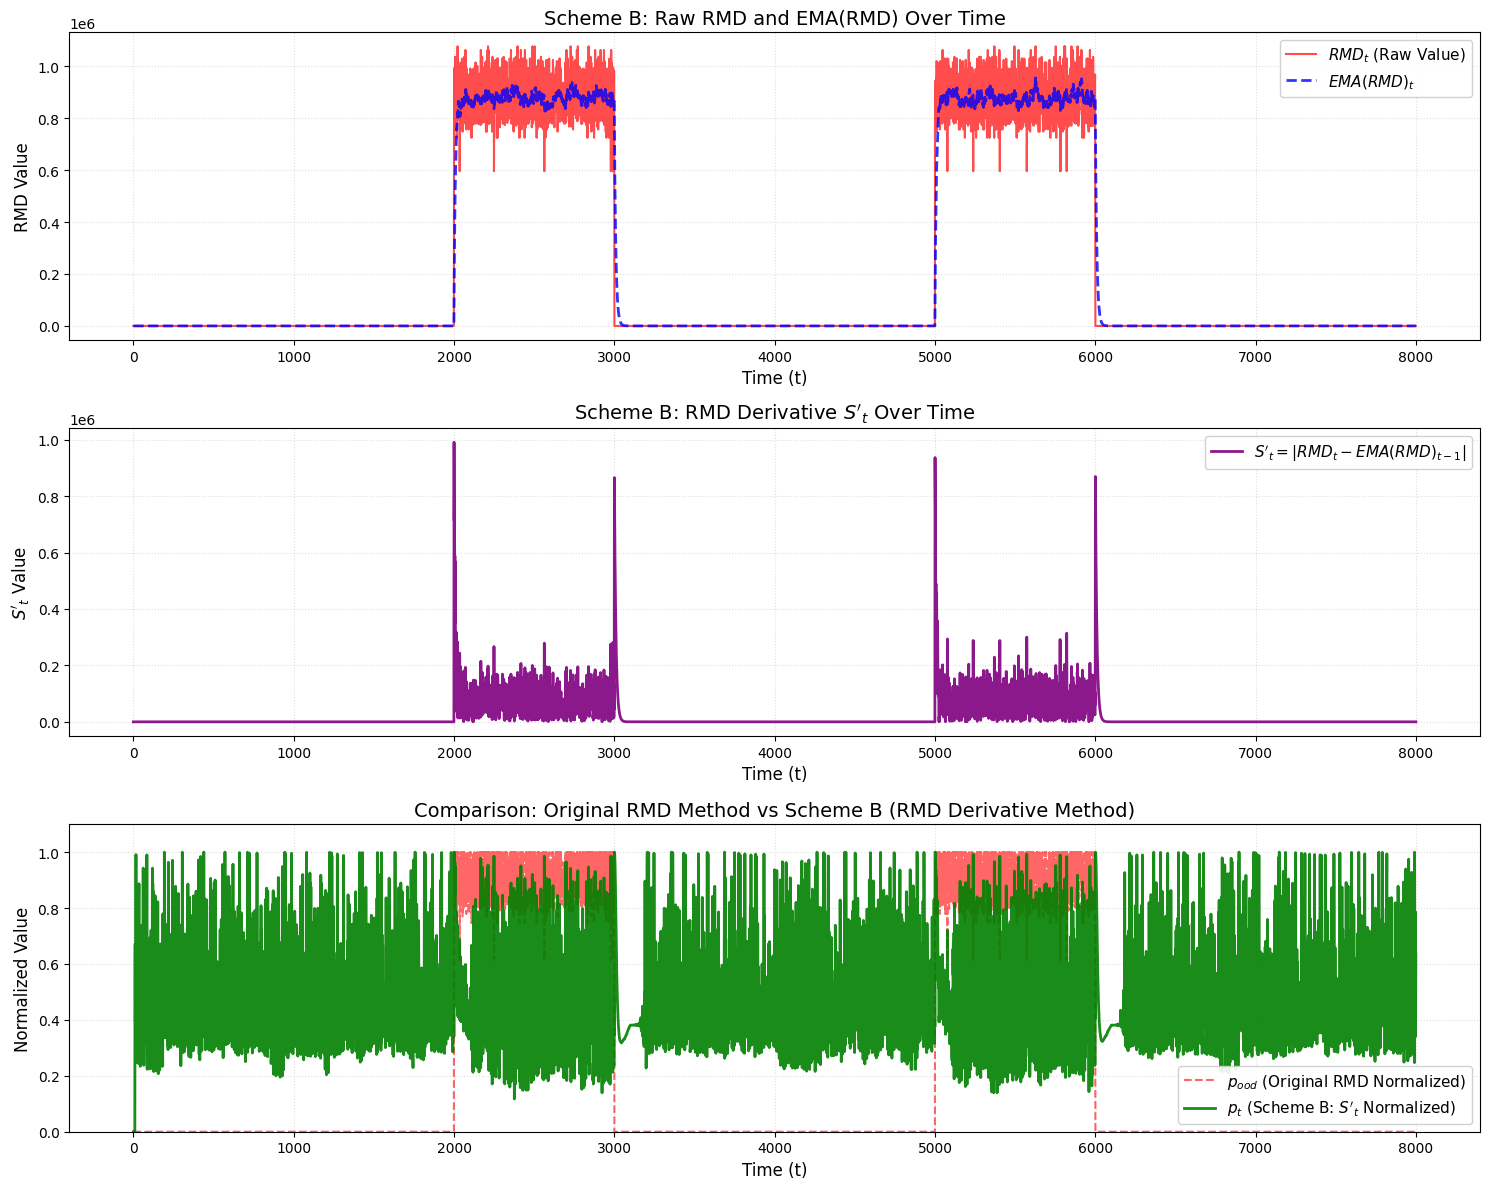


Scheme B Statistics:
  S'_t Mean: 22870.2213
  S'_t Std: 59827.3968
  S'_t Max: 991114.0376
  S'_t Min: 0.0000
  p_t Mean: 0.4824
  p_t Std: 0.1801


In [163]:
# --- Plot Scheme B Key Metrics: RMD, EMA(RMD), S'_t and p_t ---
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Subplot 1: Raw RMD and EMA(RMD)
axes[0].plot(rmd_raw, label='$RMD_t$ (Raw Value)', color='red', linewidth=1.5, alpha=0.7)
axes[0].plot(ema_rmd_history, label='$EMA(RMD)_t$', color='blue', linewidth=2, alpha=0.8, linestyle='--')
axes[0].set_title('Scheme B: Raw RMD and EMA(RMD) Over Time', fontsize=14)
axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel('RMD Value', fontsize=12)
axes[0].legend(fontsize=11, framealpha=0.9)
axes[0].grid(True, linestyle=':', alpha=0.4)

# Subplot 2: S'_t = |RMD_t - EMA(RMD)_{t-1}|
axes[1].plot(s_prime_history, label="$S'_t = |RMD_t - EMA(RMD)_{t-1}|$", color='purple', linewidth=2, alpha=0.9)
axes[1].set_title("Scheme B: RMD Derivative $S'_t$ Over Time", fontsize=14)
axes[1].set_xlabel('Time (t)', fontsize=12)
axes[1].set_ylabel("$S'_t$ Value", fontsize=12)
axes[1].legend(fontsize=11, framealpha=0.9)
axes[1].grid(True, linestyle=':', alpha=0.4)

# # Subplot 3: p_t (normalized S'_t) and p_gap
# axes[2].plot(p_t_history, label='$p_t$ (from $S\'_t$, normalized)', color='green', linewidth=2, alpha=0.8)
# axes[2].plot(p_gap_history, label='$p_{gap}$ (error gap-based)', color='orange', linewidth=2, alpha=0.8, linestyle=':')
# axes[2].set_title('$p_t$ and $p_{gap}$ Over Time (Used to Control $\\gamma_t$)', fontsize=14)
# axes[2].set_xlabel('Time (t)', fontsize=12)
# axes[2].set_ylabel('Probability Value', fontsize=12)
# axes[2].legend(fontsize=11, framealpha=0.9)
# axes[2].grid(True, linestyle=':', alpha=0.4)
# axes[2].set_ylim(0, 1.1)

# Subplot 4: Comparison of Original RMD vs S'_t (normalized) to understand Scheme B effect
axes[2].plot(ood_prob, label='$p_{ood}$ (Original RMD Normalized)', color='red', linewidth=1.5, alpha=0.6, linestyle='--')
axes[2].plot(p_t_history, label='$p_t$ (Scheme B: $S\'_t$ Normalized)', color='green', linewidth=2, alpha=0.9)
axes[2].set_title('Comparison: Original RMD Method vs Scheme B (RMD Derivative Method)', fontsize=14)
axes[2].set_xlabel('Time (t)', fontsize=12)
axes[2].set_ylabel('Normalized Value', fontsize=12)
axes[2].legend(fontsize=11, framealpha=0.9)
axes[2].grid(True, linestyle=':', alpha=0.4)
axes[2].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print(f"\nScheme B Statistics:")
print(f"  S'_t Mean: {np.mean(s_prime_history):.4f}")
print(f"  S'_t Std: {np.std(s_prime_history):.4f}")
print(f"  S'_t Max: {np.max(s_prime_history):.4f}")
print(f"  S'_t Min: {np.min(s_prime_history):.4f}")
print(f"  p_t Mean: {np.mean(p_t_history):.4f}")
print(f"  p_t Std: {np.std(p_t_history):.4f}")


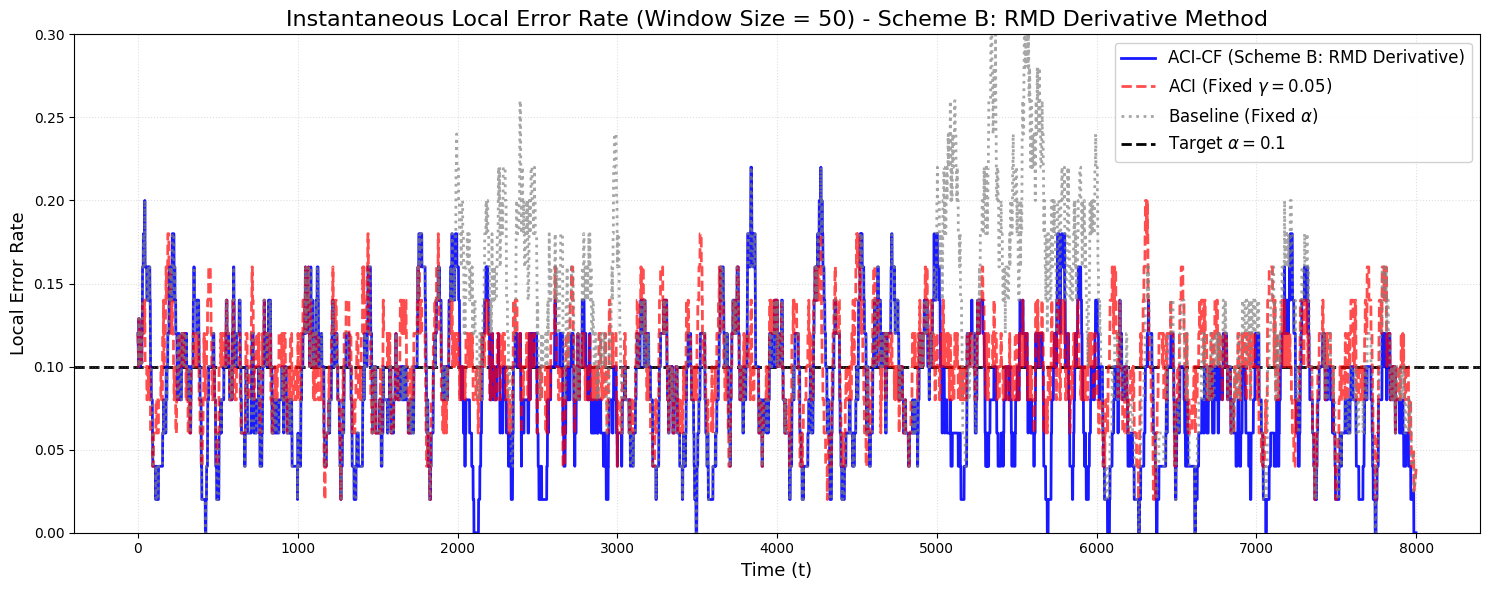

In [164]:
# --- "Instantaneous Local Error Rate Plot" ---
# 计算瞬时局部错误率（使用滑动窗口）

LOCAL_WINDOW_SIZE = 50  # 用于计算局部错误率的窗口大小

err_baseline_arr = np.array(err_baseline)
err_aci_fixed_arr = np.array(err_aci_fixed)
err_aci_ours_arr = np.array(err_aci_ours)

def compute_local_error_rate(err_array, window_size):
    """计算瞬时局部错误率"""
    local_error_rate = np.zeros(len(err_array))
    for t in range(len(err_array)):
        start_idx = max(0, t - window_size//2)
        local_error_rate[t] = np.mean(err_array[start_idx:t+window_size//2])
    return local_error_rate

local_err_baseline = compute_local_error_rate(err_baseline_arr, LOCAL_WINDOW_SIZE)
local_err_aci_fixed = compute_local_error_rate(err_aci_fixed_arr, LOCAL_WINDOW_SIZE)
local_err_aci_ours = compute_local_error_rate(err_aci_ours_arr, LOCAL_WINDOW_SIZE)

# 绘图
plt.figure(figsize=(15, 6))
plt.plot(local_err_aci_ours, label="ACI-CF (Scheme B: RMD Derivative)", color='blue', linewidth=2, alpha=0.9)
plt.plot(local_err_aci_fixed, label=f"ACI (Fixed $\\gamma={GAMMA_FIXED}$)", color='red', linewidth=2, alpha=0.7, linestyle='--')
plt.plot(local_err_baseline, label="Baseline (Fixed $\\alpha$)", color='gray', linewidth=2, alpha=0.7, linestyle=':')
plt.axhline(TARGET_ALPHA, color='black', linestyle='--', linewidth=2, label=f'Target $\\alpha={TARGET_ALPHA}$', zorder=0)

plt.title(f"Instantaneous Local Error Rate (Window Size = {LOCAL_WINDOW_SIZE}) - Scheme B: RMD Derivative Method", fontsize=16)
plt.xlabel("Time (t)", fontsize=13)
plt.ylabel("Local Error Rate", fontsize=13)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.4)
plt.ylim(0, max(0.3, TARGET_ALPHA * 3))
plt.tight_layout()
plt.show()


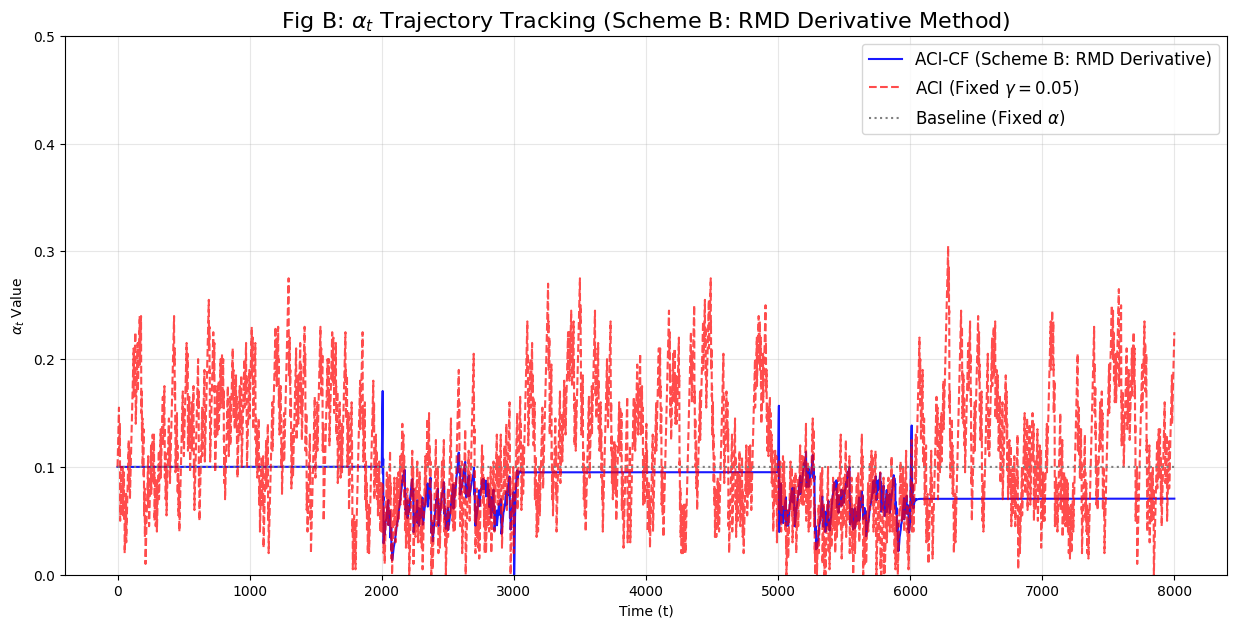

In [165]:
# --- "Money Plot": 追踪 α_t ---
plt.figure(figsize=(15, 7))
plt.plot(alpha_aci_ours, label="ACI-CF (Scheme B: RMD Derivative)", color='blue', alpha=0.9)
plt.plot(alpha_aci_fixed, label=f"ACI (Fixed $\\gamma={GAMMA_FIXED}$)", color='red', alpha=0.7, linestyle='--')
plt.plot(alpha_baseline, label="Baseline (Fixed $\\alpha$)", color='gray', linestyle=':')
plt.title("Fig B: $\\alpha_t$ Trajectory Tracking (Scheme B: RMD Derivative Method)", fontsize=16)
plt.xlabel("Time (t)")
plt.ylabel("$\\alpha_t$ Value")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.5)
plt.show()


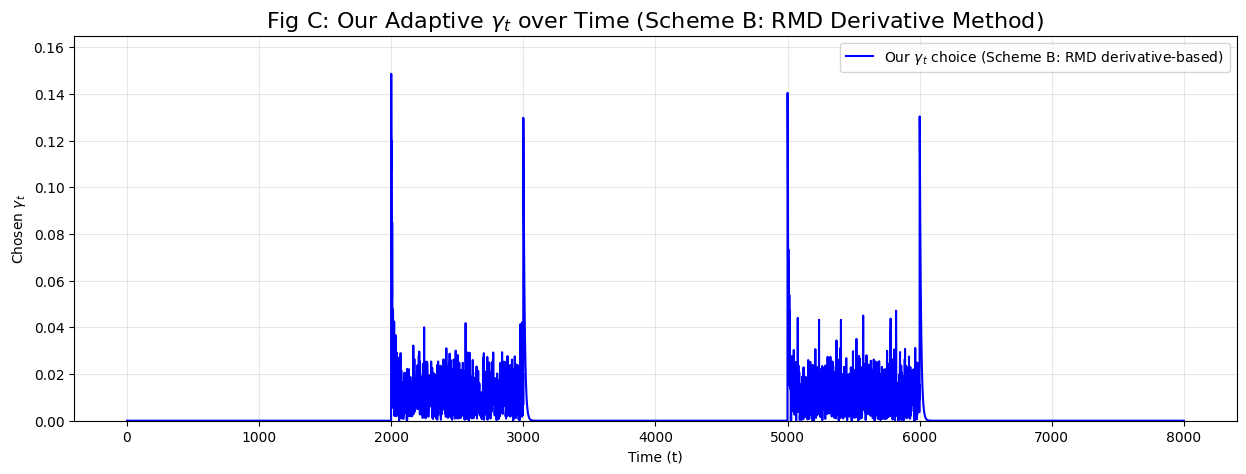

In [166]:
# --- "Why Plot": 我们选择的 γ_t (方案B: 基于 RMD 差分) ---
plt.figure(figsize=(15, 5))
plt.plot(gamma_t_history, label="Our $\\gamma_t$ choice (Scheme B: RMD derivative-based)", color='blue')
plt.title("Fig C: Our Adaptive $\\gamma_t$ over Time (Scheme B: RMD Derivative Method)", fontsize=16)
plt.xlabel("Time (t)")
plt.ylabel("Chosen $\\gamma_t$")
plt.ylim(0, GAMMA_MAX * 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


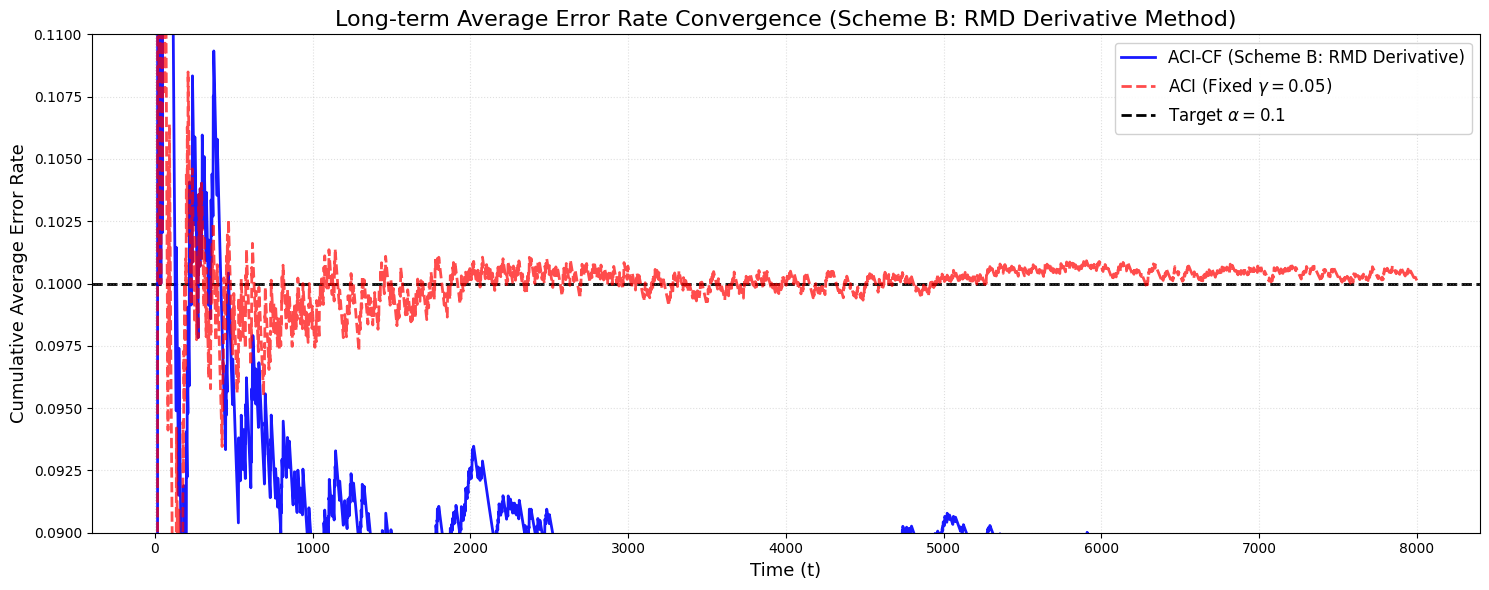

In [167]:
# --- "Long-term Average Error Rate Convergence" ---
err_baseline_arr = np.array(err_baseline)
err_aci_fixed_arr = np.array(err_aci_fixed)
err_aci_ours_arr = np.array(err_aci_ours)

def compute_cumulative_avg_error(err_array):
    """计算累积平均错误率"""
    cumulative_avg = np.zeros(len(err_array))
    for t in range(len(err_array)):
        cumulative_avg[t] = np.mean(err_array[0:t+1])
    return cumulative_avg

cumulative_avg_baseline = compute_cumulative_avg_error(err_baseline_arr)
cumulative_avg_aci_fixed = compute_cumulative_avg_error(err_aci_fixed_arr)
cumulative_avg_aci_ours = compute_cumulative_avg_error(err_aci_ours_arr)

# 绘图
plt.figure(figsize=(15, 6))
plt.plot(cumulative_avg_aci_ours, label="ACI-CF (Scheme B: RMD Derivative)", color='blue', linewidth=2, alpha=0.9)
plt.plot(cumulative_avg_aci_fixed, label=f"ACI (Fixed $\\gamma={GAMMA_FIXED}$)", color='red', linewidth=2, alpha=0.7, linestyle='--')
plt.axhline(TARGET_ALPHA, color='black', linestyle='--', linewidth=2, label=f'Target $\\alpha={TARGET_ALPHA}$', zorder=0)

plt.title("Long-term Average Error Rate Convergence (Scheme B: RMD Derivative Method)", fontsize=16)
plt.xlabel("Time (t)", fontsize=13)
plt.ylabel("Cumulative Average Error Rate", fontsize=13)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.4)
plt.ylim(TARGET_ALPHA * 0.9, TARGET_ALPHA * 1.1)
plt.tight_layout()
plt.show()


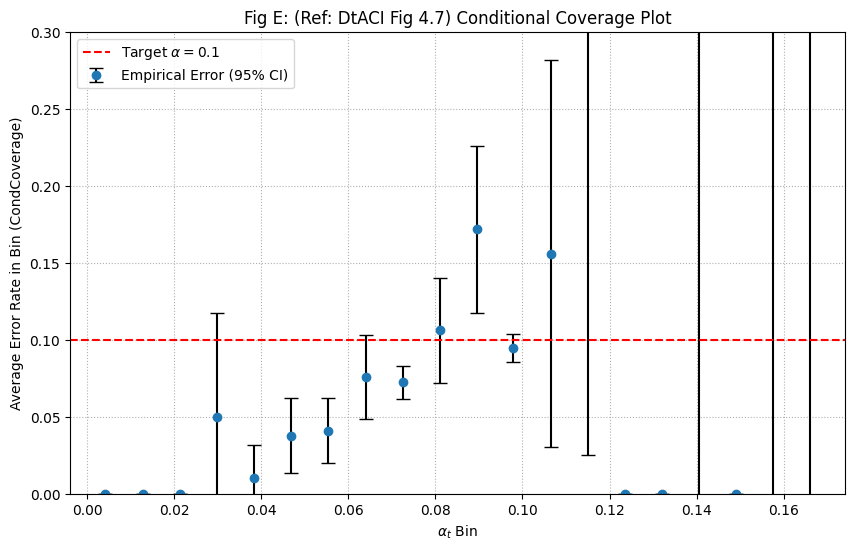

In [168]:
# --- "Stability Plot": 条件覆盖率 (Ref: Fig 4.7)  ---
df = pd.DataFrame({
    'alpha_t': alpha_aci_ours,
    'error': err_aci_ours
})

# 1. 将 α_t 分箱 (binning)
num_bins = 20
df['alpha_bin'] = pd.cut(df['alpha_t'], bins=num_bins)

# 2. 计算每个 bin 的统计数据（均值和样本数）
grouped = df.groupby('alpha_bin', observed=True)['error']
stats = grouped.agg(['mean', 'count'])

# 3. 计算 95% 置信区间 (95% CI)
p = stats['mean']
n = stats['count']
sem = np.sqrt(p * (1 - p) / n)
z_score = st.norm.ppf(0.975)  # 约等于 1.96
y_err = z_score * sem

# 准备绘图
bin_centers = [b.mid for b in stats.index]

# 4. 绘图 (使用 plt.errorbar)
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, stats['mean'], yerr=y_err, fmt='o', color='C0',
             ecolor='black', capsize=5, label='Empirical Error (95% CI)')

plt.axhline(TARGET_ALPHA, color='red', linestyle='--', label=f'Target $\\alpha = {TARGET_ALPHA}$')

plt.xlabel("$\\alpha_t$ Bin")
plt.ylabel("Average Error Rate in Bin (CondCoverage)")
plt.title("Fig E: (Ref: DtACI Fig 4.7) Conditional Coverage Plot")
plt.legend()
plt.ylim(TARGET_ALPHA - 0.1, TARGET_ALPHA + 0.2)
plt.grid(True, linestyle=':')
plt.show()
